<h1>Forecasting Innovational Outliers using Autoencoder-LSTM in Time Series</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import datetime as dt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys
import time
from collections import Counter
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
sns.set_theme()

## Load and processing data

In [2]:
df = pd.read_csv('../data/small_data.csv', usecols=['time', 'temp_ice', 'temp_inside', 'temp_outside'])
df['time'] = pd.to_datetime(df['time'])
df.head()

time  temp_ice  temp_inside  temp_outside
0 2022-09-27 10:11:00 -4.558333     7.940385      6.387500
1 2022-09-27 10:12:00 -4.485500     7.948077      6.446833
2 2022-09-27 10:13:00 -4.356587     7.937500      6.506166
3 2022-09-27 10:14:00 -4.438758     7.950000      6.565500
4 2022-09-27 10:15:00 -4.393290     7.900000      6.624833

In [69]:
# detect resurfacing
df = (df
 # Handling anomalous values 
 .assign(temp_ice=lambda df: df['temp_ice'].clip(lower=-10, upper=3))
 .assign(temp_ice=lambda df: df['temp_ice'].ffill())
 # Differentialize the exponentially smoothed series to find the resurfacing 
 .assign(diff=lambda df: df['temp_ice'].ewm(span=60).mean().diff())
 .assign(resurfacing=lambda df: np.where(df['diff'] > 0.03, 1, 0))
 # Create a trait to calculate the time between resurfacing
 .assign(diff_time=dt.timedelta(minutes=30))
 )

# Counting the correct number of resurfacing
df.loc[df['resurfacing'] == 1, 'diff_time'] = df.loc[df['resurfacing'] == 1, 'time'].diff().fillna(dt.timedelta(minutes=30))
df.loc[df['diff_time'] < dt.timedelta(minutes=30), 'resurfacing'] = 0
df = df.drop(columns=['diff', 'diff_time'])

In [70]:
# sin and cos component features
df['min_sin'] = np.sin(2 * np.pi * df['time'].dt.minute / 60)
df['min_cos'] = np.cos(2 * np.pi * df['time'].dt.minute / 60)
df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['time'].dt.day_of_week / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['time'].dt.day_of_week / 7)

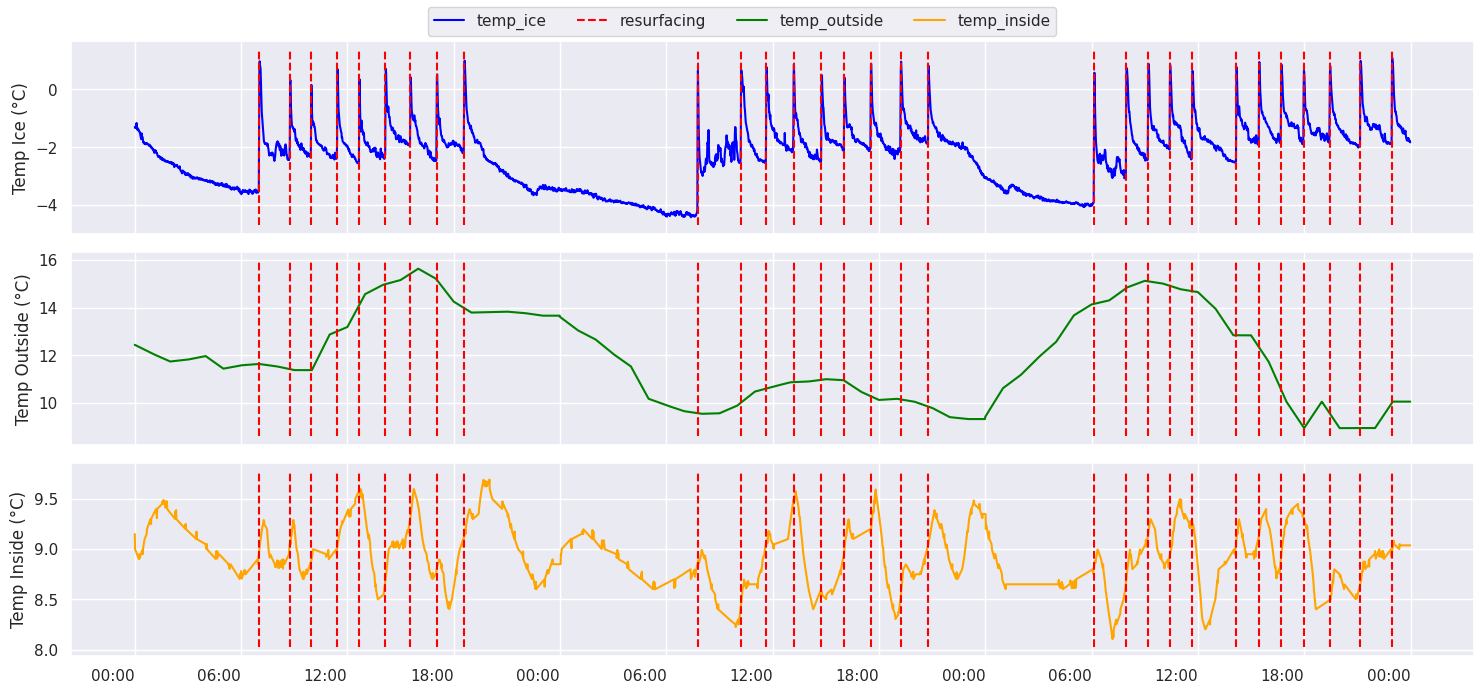

In [71]:
# Sampling the data for the desired time period
df_sample = df.set_index('time').loc['2022-10-01':'2022-10-03']

# Create the figure and axes for the subgraphs
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 7), sharex=True)

# Temperature signatures on individual subplots
axes[0].plot(df_sample.index, df_sample['temp_ice'], label='temp_ice', color='blue')
axes[0].set_ylabel('Temp Ice (°C)')

axes[1].plot(df_sample.index, df_sample['temp_outside'], label='temp_outside', color='green')
axes[1].set_ylabel('Temp Outside (°C)')

axes[2].plot(df_sample.index, df_sample['temp_inside'], label='temp_inside', color='orange')
axes[2].set_ylabel('Temp Inside (°C)')

# Add vertical lines for resurfacing
for ax in axes:
    ax.vlines(df_sample[df_sample['resurfacing'] == 1].index, 
              ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], 
              color='red', linestyle='--', label='resurfacing')

# Create a common legend for all charts
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
fig.legend(handles, labels, loc='upper center', ncol=6)

# Formatting the time axis (x-axis)
locator = mdates.AutoDateLocator(minticks=5, maxticks=20)  # Automatic selection of timestamps
formatter = mdates.DateFormatter('%H:%M')  # Format timestamps without seconds
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)

# Rotate the x-axis labels for better readability
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=0, ha='right')

# Set compact layout of subgraphs
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the overall legend
plt.show()


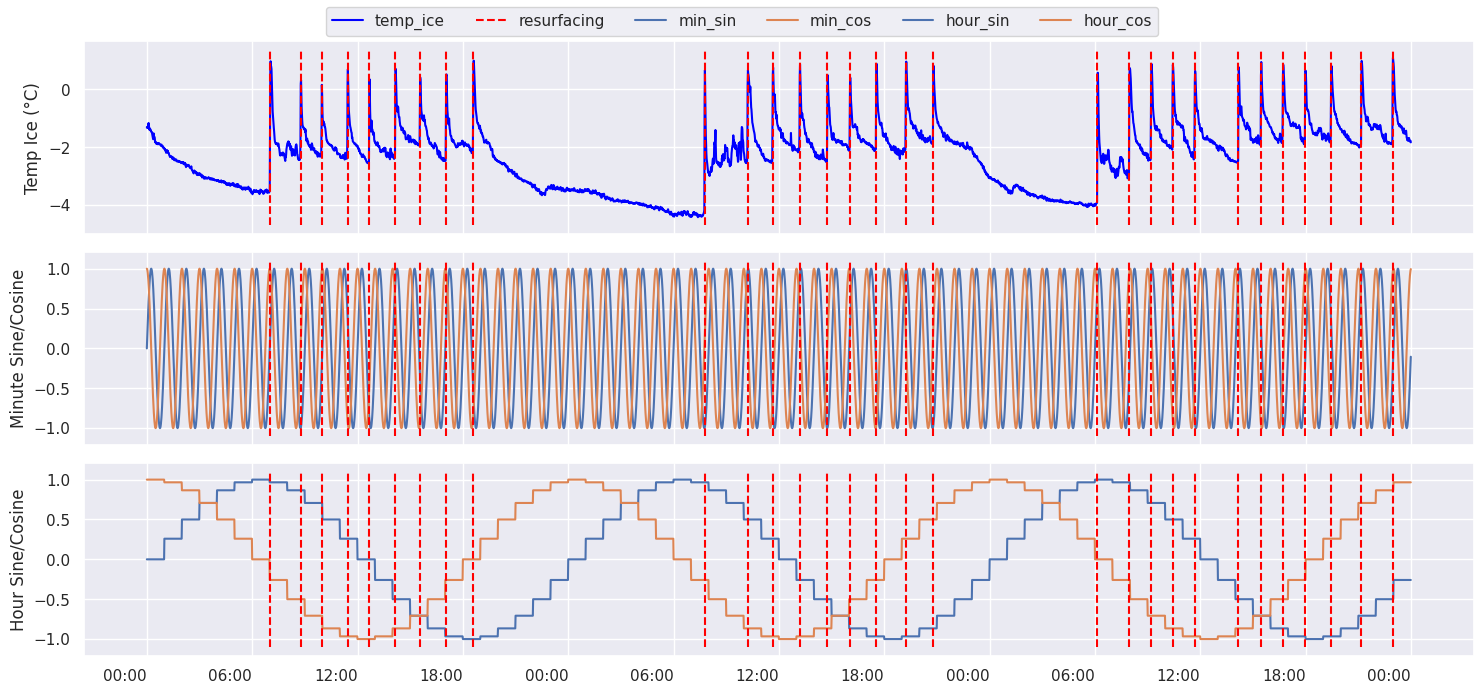

In [72]:
# Create the figure and axes for the subgraphs
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 7), sharex=True)

# Temperature signatures on individual subplots
axes[0].plot(df_sample.index, df_sample['temp_ice'], label='temp_ice', color='blue')
axes[0].set_ylabel('Temp Ice (°C)')

axes[1].plot(df_sample.index, df_sample['min_sin'], label='min_sin')
axes[1].plot(df_sample.index, df_sample['min_cos'], label='min_cos')
axes[1].set_ylabel('Minute Sine/Cosine')

axes[2].plot(df_sample.index, df_sample['hour_sin'], label='hour_sin')
axes[2].plot(df_sample.index, df_sample['hour_cos'], label='hour_cos')
axes[2].set_ylabel('Hour Sine/Cosine')

# Add vertical lines for resurfacing
for ax in axes:
    ax.vlines(df_sample[df_sample['resurfacing'] == 1].index, 
              ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], 
              color='red', linestyle='--', label='resurfacing')

# Create a common legend for all charts
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
fig.legend(handles, labels, loc='upper center', ncol=6)

# Formatting the time axis (x-axis)
locator = mdates.AutoDateLocator(minticks=5, maxticks=20)  # Automatic selection of timestamps
formatter = mdates.DateFormatter('%H:%M')  # Format timestamps without seconds
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)

# Rotate the x-axis labels for better readability
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=0, ha='right')

# Set compact layout of subgraphs
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the overall legend
plt.show()


## Classical ML

In [73]:
sequence_length = 120
prediction_offset = 30

def generate_sequence(data, sequence_length, features):
    for feature in features:
        for lag in range(1, sequence_length + 1):
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
    
    # Drop initial rows with NaN
    data = data.iloc[sequence_length:].reset_index(drop=True)
    return data


# Prepare feature matrix X and target vector y
temp_features = ['temp_ice', 'temp_inside', 'temp_outside']
cycle_features = ['min_sin', 'min_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

# Create a copy of the dataframe to avoid modifying the original data
sequence_df = df.copy(deep=True)
# Initialize standard scaler for temperature features
scaler = StandardScaler()
sequence_df[temp_features] = scaler.fit_transform(sequence_df[temp_features])

# Generate lagged features for temperature features
sequence_df = generate_sequence(sequence_df, sequence_length, temp_features)

# Define the target variable with a prediction offset
sequence_df['resurfacing_future'] = sequence_df['resurfacing'].shift(-prediction_offset)
# Drop rows with NaN values in the target column
sequence_df.dropna(subset=['resurfacing_future'], inplace=True, ignore_index=True)


# Get indices where resurfacing events occur
# resurfacing_indices = sequence_df.index[sequence_df['resurfacing_future'] == 1].tolist()

# For each resurfacing event, set the target variable to 1 for ±5 minutes
# window_size = 5  # 5 minutes before and after
# for idx in resurfacing_indices:
#     start_idx = max(idx - window_size, 0)
#     end_idx = min(idx + window_size + 1, len(sequence_df))
#     sequence_df.loc[start_idx:end_idx, 'resurfacing_future'] = 1

In [74]:
X = sequence_df[sequence_df.columns.drop(['time', 'resurfacing_future']).to_list()]
y = sequence_df['resurfacing_future']

# Split data into training and testing sets preserving temporal order
train_size = int(len(X) * 0.7)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [75]:
# Define models to evaluate
class_weight_ratio = Counter(y_train)[0] / Counter(y_train)[1]

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Support Vector Machine': SVC(probability=True, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(scale_pos_weight=class_weight_ratio, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(class_weight='balanced', verbose=-1),
    'CatBoost': CatBoostClassifier(verbose=0, class_weights=[1, class_weight_ratio], allow_writing_files=False)
}

In [76]:
def calculate_metrics(model, y_test, y_pred, y_proba):
    accuracy = accuracy_score(y_test, y_pred)
    # calculate metrics for negative class
    precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)
    # calculate metrics for positive class
    precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    results = {
        'Model': type(model).__name__,
        'Accuracy': accuracy,
        'Precision (0)': precision_0,
        'Recall (0)': recall_0,
        'F1-Score (0)': f1_0,
        'Precision (1)': precision_1,
        'Recall (1)': recall_1,
        'F1-Score (1)': f1_1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': conf_matrix
    }

    print(f'{type(model).__name__}:', conf_matrix, sep='\n')
    
    return results

In [77]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    return y_pred, y_proba, training_time


prediction_df = sequence_df.loc[X_test.index, ['time', 'resurfacing']].copy()
metrics_list = []
# Evaluate each model
for name, model in models.items():
    y_pred, y_proba, training_time = evaluate_model(model, X_train, y_train, X_test)
    prediction_df['Target ' + name] = y_pred
    prediction_df['Probability ' + name] = y_proba
    results = calculate_metrics(model, y_test, y_pred, y_proba)
    results['Training Time (seconds)'] = training_time
    metrics_list.append(results)


metrics_df = pd.DataFrame(metrics_list)
metrics_df.round(2)

LogisticRegression:
[[10151  1732]
 [   27    45]]
SVC:
[[10773  1110]
 [   33    39]]
RandomForestClassifier:
[[11883     0]
 [   72     0]]
XGBClassifier:
[[11866    17]
 [   68     4]]
LGBMClassifier:
[[11814    69]
 [   62    10]]
CatBoostClassifier:
[[11864    19]
 [   66     6]]


Model  Accuracy  Precision (0)  Recall (0)  F1-Score (0)   
0      LogisticRegression      0.85           1.00        0.85          0.92  \
1                     SVC      0.90           1.00        0.91          0.95   
2  RandomForestClassifier      0.99           0.99        1.00          1.00   
3           XGBClassifier      0.99           0.99        1.00          1.00   
4          LGBMClassifier      0.99           0.99        0.99          0.99   
5      CatBoostClassifier      0.99           0.99        1.00          1.00   

   Precision (1)  Recall (1)  F1-Score (1)  ROC AUC   
0           0.03        0.62          0.05     0.81  \
1           0.03        0.54          0.06     0.82   
2           0.00        0.00          0.00     0.69   
3           0.19        0.06          0.09     0.82   
4           0.13        0.14          0.13     0.84   
5           0.24        0.08          0.12     0.84   

            Confusion Matrix  Training Time (seconds)  
0  [[10151, 1732], [27, 45]]                     9.86  
1  [[10773, 1110], [33, 39]]                   325.91  
2      [[11883, 0], [72, 0]]                    18.44  
3     [[11866, 17], [68, 4]]                     3.88  
4    [[11814, 69], [62, 10]]                     3.72  
5     [[11864, 19], [66, 6]]                    37.38

In [79]:
prediction_df['temp_ice'] = scaler.inverse_transform(X_test[temp_features])[:, 0]

In [81]:
df_sample = prediction_df.iloc[:3*1440]

fig = make_subplots(rows=3, cols=1, vertical_spacing=0.02, shared_xaxes=True)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['temp_ice'], name='temp_ice'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['resurfacing'], name='resurfacing'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Target Logistic Regression'], name='Target Logistic Regression'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Target Support Vector Machine'], name='Target Support Vector Machine'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Target Random Forest'], name='Target Random Forest'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Target XGBoost'], name='Target XGBoost'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Target LightGBM'], name='Target LightGBM'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Target CatBoost'], name='Target CatBoost'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Probability Logistic Regression'], name='Probability Logistic Regression'), row=3, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Probability Support Vector Machine'], name='Probability Support Vector Machine'), row=3, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Probability Random Forest'], name='Probability Random Forest'), row=3, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Probability XGBoost'], name='Probability XGBoost'), row=3, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Probability LightGBM'], name='Probability LightGBM'), row=3, col=1)
fig.add_trace(go.Scatter(x=df_sample['time'], y=df_sample['Probability CatBoost'], name='Probability CatBoost'), row=3, col=1)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                #   width=1500,
                  height=700,

                #   font_color='#837A4F',
                #   title_font_color='#837A4F'
                  )
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Температура: %{y:.2f}°C', row=1, col=1)
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Заливка: %{y:.2f}', row=2, col=1)
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Вероятность: %{y:.2f}', row=3, col=1)
fig.update_yaxes(title_text='°C', row=1, col=1)

## Deep learning

### Create Dataset

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, path, sequence_length, prediction_offset, split='train', train_size=0.7, val_size=0.15, scaler=None):
        '''
        Args:
            path (str): path to csv file with data
            sequence_length (int): sequence length for input data
            prediction_offset (int): steps count forward for prediction (horizon)
            split (str): type of sample ('train', 'val', 'test')
            train_size (float): data proportion for train sample
            val_size (float): data proportion for val sample -> test_size = 1 - train_size - val_size
            scaler (sklearn.preprocessing)
        '''
        
        self.temp_features = ['temp_ice', 'temp_inside', 'temp_outside']
        cycle_features = ['min_sin', 'min_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

        self.data = pd.read_csv(path, usecols=['time'] + self.temp_features)[:1440*3]
        self.data['time'] = pd.to_datetime(self.data['time'])
        self.sequence_length = sequence_length
        self.prediction_offset = prediction_offset
        self.scaler = scaler
        self.features = self.temp_features + cycle_features

        self.extract_resurfacing()
        self.generate_cycle_features()

        # Define the target variable with a prediction offset
        self.data['resurfacing_future'] = self.data['resurfacing'].shift(-prediction_offset)
        # Drop rows with NaN values in the target column
        self.data.dropna(subset=['resurfacing_future'], inplace=True, ignore_index=True)

        # split train, validation and test sampling
        n = len(self.data)
        train_end = int(n * train_size)
        val_end = train_end + int(n * val_size)

        if split == 'train':
            self.data = self.data[:train_end]
            self.scaler = StandardScaler()
            self.scaler.fit(self.data[self.temp_features])
        elif split == 'val':
            self.data = self.data[train_end:val_end]
        elif split == 'test':
            self.data = self.data[val_end:]
        else:
            raise ValueError('split must be "train", "val" or "test"')

        if self.scaler is not None:
            self.data[self.temp_features] = self.scaler.transform(self.data[self.temp_features])
        else:
            raise ValueError('Scaler not defined, create a train_dataset instance for it')
        

    def __len__(self):
        return len(self.data) - self.sequence_length - self.prediction_offset + 1
    

    def __getitem__(self, idx):
        x = self.data.iloc[idx: idx + self.sequence_length][self.features].values
        y = self.data.iloc[idx + self.sequence_length + self.prediction_offset - 1]['resurfacing_future']

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    

    def extract_resurfacing(self):
        # detect resurfacing
        self.data = (self.data
        # Handling anomalous values 
        .assign(temp_ice=lambda df: df['temp_ice'].clip(lower=-10, upper=3))
        .assign(temp_ice=lambda df: df['temp_ice'].ffill())
        # Differentialize the exponentially smoothed series to find the resurfacing 
        .assign(diff=lambda df: df['temp_ice'].ewm(span=60).mean().diff())
        .assign(resurfacing=lambda df: np.where(df['diff'] > 0.03, 1, 0))
        # Create a trait to calculate the time between resurfacing
        .assign(diff_time=dt.timedelta(minutes=30))
        )

        # Counting the correct number of resurfacing
        self.data.loc[self.data['resurfacing'] == 1, 'diff_time'] = self.data.loc[self.data['resurfacing'] == 1, 'time'].diff().fillna(dt.timedelta(minutes=30))
        self.data.loc[self.data['diff_time'] < dt.timedelta(minutes=30), 'resurfacing'] = 0
        self.data = self.data.drop(columns=['diff', 'diff_time'])
    

    def generate_cycle_features(self):
        self.data['time'] = pd.to_datetime(self.data['time'])
        self.data['min_sin'] = np.sin(2 * np.pi * self.data['time'].dt.minute / 60)
        self.data['min_cos'] = np.cos(2 * np.pi * self.data['time'].dt.minute / 60)
        self.data['hour_sin'] = np.sin(2 * np.pi * self.data['time'].dt.hour / 24)
        self.data['hour_cos'] = np.cos(2 * np.pi * self.data['time'].dt.hour / 24)
        self.data['dow_sin'] = np.sin(2 * np.pi * self.data['time'].dt.day_of_week / 7)
        self.data['dow_cos'] = np.cos(2 * np.pi * self.data['time'].dt.day_of_week / 7)

    
    def inverse_transform(self):
        return self.scaler.inverse_transform(self.data[self.temp_features])

    

path = '../data/small_data.csv'
sequence_length = 120
prediction_offset = 30
batch_size = 64

train_dataset = TimeSeriesDataset(path, sequence_length, prediction_offset, split='train', train_size=0.7, val_size=0.15)
val_dataset = TimeSeriesDataset(path, sequence_length, prediction_offset, split='val', train_size=0.7, val_size=0.15, scaler=train_dataset.scaler)
test_dataset = TimeSeriesDataset(path, sequence_length, prediction_offset, split='test', train_size=0.7, val_size=0.15, scaler=train_dataset.scaler)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Train model

In [18]:
# training cycle
def train_model(model, loss_model, opt, lr_scheduler, model_name, checkpoint):
    # Load previous training data from checkpoint
    train_loss = checkpoint['loss']['train_loss']
    train_metric = checkpoint['metric']['train_metric']
    val_loss = checkpoint['loss']['val_loss']
    val_metric = checkpoint['metric']['val_metric']
    lr_list = checkpoint['lr']
    best_loss = checkpoint['loss']['best_loss']
    save_epoch = checkpoint['epoch']['save_epoch']
    EPOCHS = checkpoint['epoch']['EPOCHS']

    count = 0   # Initialize count for early stopping
    for epoch in range(save_epoch, EPOCHS):

        # model train phase
        model.train()               # Set model to trainig mode
        running_train_loss = []     # List to store loss for each batch in training
        running_train_metric = []   # List to store recall for each batch in training
        train_loop = tqdm(train_loader, leave=False, file=sys.stdout) # Progress bar for training loop
        for X, y in train_loop:
            # Move input and labels to the appropriate device
            X = X.to(device)
            y = y.to(device)

            # Forward pass through the model to get predictions
            y_pred = model(X)
            # Calculate loss between predicted and true labels
            loss = loss_model(y_pred, y)
    
            # Transform predicted logits to binary labels using threshold of 0.2
            y_pred_labels = (y_pred >= 0.2).float()

            # Calculate true positives and false negatives for recall calculation
            tp = ((y_pred_labels == 1) & (y == 1)).sum().item() # True positives
            fn = ((y_pred_labels == 0) & (y == 1)).sum().item() # False negatives

            # Calculate recall metrics
            recall = tp / (tp + fn + 1e-8) # Add small valur to avoid division by zero

            # Backward pass and optimization
            opt.zero_grad()         # Zero the gradient buffers
            loss.backward()     # Backpropagate the loss
            opt.step()              # Update model parameters

            # Append current batch loss and recall to running lists
            running_train_loss.append(loss.item())
            running_train_metric.append(recall)

            # Calculate mean training loss and metric up to the current batch
            mean_train_loss = sum(running_train_loss) / len(running_train_loss)
            mean_train_metric = sum(running_train_metric) / len(running_train_metric)

            # Update progress bar description with current epoch
            train_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss={mean_train_loss:.4f}')
        

        # Append mean training loss and recall for the epoch
        train_loss.append(mean_train_loss)
        train_metric.append(mean_train_metric)


        # model validation phase
        model.eval()    # Set model to evaluate mode
        with torch.no_grad():           # Disable gradient calculation for validation
            running_val_loss = []       # List to store loss for each batch in validation
            running_val_metric = []     # List to store recall for each batch in validation
            for X, y in val_loader:
                # Move input and labels to the appropriate device
                X = X.to(device)
                y = y.to(device)

                # Forward pass through the model to get predictions
                y_pred = model(X)
                # Calculate loss between predicted and true labels
                loss = loss_model(y_pred, y)                

                # Transform predicted logits to binary labels using threshold of 0.2
                y_pred_labels = (y_pred >= 0.2).float()

                # Calculate true positives and false negatives for recall calculations
                tp = ((y_pred_labels == 1) & (y == 1)).sum().item()     # True positives
                fn = ((y_pred_labels == 0) & (y == 1)).sum().item()     # False positives

                # Calculate recall metric
                recall = tp / (tp + fn + 1e-8)  # Add small value to avoid division by zero

                # Append current batch loss and recall to running lists
                running_val_loss.append(loss.item())
                running_val_metric.append(recall)

            # Calculate mean validation loss and recall for the epoch
            mean_val_loss = sum(running_val_loss) / len(running_val_loss)
            mean_val_metric = sum(running_val_metric) / len(running_val_metric)
            
            # Append mean validation loss and recall for the epoch
            val_loss.append(mean_val_loss)
            val_metric.append(mean_val_metric)
            
        # Adjust the learning rate based on validation loss
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler._last_lr[0]       # Get the current learning rate
        lr_list.append(lr)

        # Print summary of the epoch's results
        print(f'Epoch [{epoch + 1}/{EPOCHS}], ' 
            f'train_loss={mean_train_loss:.4f}, train_metric={mean_train_metric:.4f}, '
            f'val_loss={mean_val_loss:.4f}, val_metric={mean_val_metric:.4f}')

        # Check if validation loss has improved significantly to save the model
        if best_loss is None or (best_loss - mean_val_loss) / best_loss > 0.01:
            best_loss = mean_val_loss

            # Update the checkpoint with current state
            checkpoint.update({
                'state_model': model.state_dict(),
                'state_opt': opt.state_dict(),
                'state_lr_scheduler': lr_scheduler.state_dict(),
                'loss': {
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'best_loss': best_loss
                },
                'metric': {
                    'train_metric': train_metric,
                    'val_metric': val_metric
                },
                'lr': lr_list,
                'epoch': {
                    'EPOCHS': EPOCHS,
                    'save_epoch': epoch
                }
            })

            # Save the model checkpoint
            torch.save(checkpoint, f'../models/anomaly_classification_models/{model_name}.pt')
            print(f'On epoch - {epoch + 1}, the model with the value of the validation loss function is saved - {mean_val_loss:.4f}', end='\n\n')
        else:
            count += 1

        # Early stopping if validation loss does not improve for 10 consecutive epochs
        if count >= 10:
            print(f'\033[31m Training stopped at epoch {epoch + 1}.\033[0m')
            break

In [15]:
def test_model(model, loss_model):
    # Initialize lists to store true labels and predicted probabilities
    y_lst = []
    y_pred_lst = []

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad(): # Disable gradient calculation for evaluation
        running_test_loss = [] # List to store loss for each batch
        running_test_metric = [] # List to store recall metric for each batch

        # Iterate over the test data loader
        for X, y in test_loader:
            # Move input and labels to the appropriate device
            X = X.to(device)
            y = y.reshape(batch_size, -1).to(device)

            # Forward pass through the model to get predictions
            y_pred = model(X)
            # Apply sigmoid to convert logits to probabilities
            y_pred_prob = torch.sigmoid(y_pred)

            # Calculate loss between predicted and true labels
            loss = loss_model(y_pred, y)                
            # Transform predicted probabilities to binary labels (threshold at 0.2)
            y_pred_labels = (y_pred >= 0.2).float()

            # Calculate true positives and false negatives for recall calculation
            tp = ((y_pred_labels == 1) & (y == 1)).sum().item() # true positives
            fn = ((y_pred_labels == 0) & (y == 1)).sum().item() # false negatives

            # Calculate recall metric
            recall = tp / (tp + fn + 1e-8)

            # Append current batch loss and recall to the respective lists
            running_test_loss.append(loss.item())
            running_test_metric.append(recall)

            # Extend the list of true labels and predicted probabilities for further analysis
            y_lst.extend(torch.squeeze(y).tolist())
            y_pred_lst.extend(torch.squeeze(y_pred_prob).tolist())

        # Calculate mean loss and recall across all batches
        mean_test_loss = sum(running_test_loss) / len(running_test_loss)
        mean_test_metric = sum(running_test_metric) / len(running_test_metric)
        
        # Print the test loss and recall metric 
        print(f'test_loss={mean_test_loss:.4f}, test_metric={mean_test_metric:.4f}')

        # Return the list of predicted probabilities
        return y_pred_lst

In [20]:
def plot_training_process(load_model_state):
    load_model_state.keys()
    train_loss = load_model_state['loss']['train_loss']
    val_loss = load_model_state['loss']['val_loss']
    train_metric = load_model_state['metric']['train_metric']
    val_metric = load_model_state['metric']['val_metric']
    lr_list = load_model_state['lr']
  
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    ax1.plot(train_loss)
    ax1.plot(val_loss)
    ax1.legend(['train_loss', 'val_loss'])

    ax2.plot(lr_list)
    ax2.legend(['learning_rate'])

    ax3.plot(train_metric)
    ax3.plot(val_metric)
    ax3.legend(['train_metric', 'val_metric'])


### Simple LSTM

In [25]:
# Calculate weigth for positive class
train_dataset.data['resurfacing'].value_counts()[0] / train_dataset.data['resurfacing'].value_counts()[1]

119.12

#### Initialization model

In [26]:
class LSTMClassifier(nn.Module):
    def __init__(self, num_features, hidden_size=64, lstm_layers=2, fc_dim=16, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers

        # Define LSTM layer with specified number of features, hidden size and layers
        self.lstm = nn.LSTM(num_features, hidden_size, lstm_layers, batch_first=True, dropout=dropout)
        # Define fully connected layers for output after LSTM
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, 1)
        )

    def forward(self, x):
        # x: [batch_size, sequence_length, num_features]
        # Initialize hidden state (h0) and cell state (c0) for LSTM
        h0 = torch.zeros(self.lstm_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.lstm_layers, x.size(0), self.hidden_size, device=x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))     # out: [batch_size, sequence_length, size]
        # Use the output from the last time step
        out = out[:, -1, :]                 # Last time step output
        # Pass through fully connected layers
        out = self.fc(out)
        return out


num_features = len(train_dataset.features)
hidden_size = 64
lstm_layers = 2

# Calculate weight for resurfacing (Class 1)
pos_weight = train_dataset.data['resurfacing'].value_counts()[0] / train_dataset.data['resurfacing'].value_counts()[1]
pos_weight = torch.tensor(pos_weight).to(device)

simple_lstm_model = LSTMClassifier(num_features, hidden_size, lstm_layers).to(device)
bce_loss_model = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
opt = torch.optim.Adam(simple_lstm_model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)


str_info = '''
class LSTMClassifier(nn.Module):
    def __init__(self, num_features, hidden_size=64, lstm_layers=2, fc_dim=16, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers

        # Define LSTM layer with specified number of features, hidden size and layers
        self.lstm = nn.LSTM(num_features, hidden_size, lstm_layers, batch_first=True, dropout=dropout)
        # Define fully connected layers for output after LSTM
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, 1)
        )

    def forward(self, x):
        # x: [batch_size, sequence_length, num_features]
        # Initialize hidden state (h0) and cell state (c0) for LSTM
        h0 = torch.zeros(self.lstm_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.lstm_layers, x.size(0), self.hidden_size, device=x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))     # out: [batch_size, sequence_length, size]
        # Use the output from the last time step
        out = out[:, -1, :]                 # Last time step output
        # Pass through fully connected layers
        out = self.fc(out)
        return out
'''


EPOCHS = 50
save_epoch = 0
train_loss = []
train_metric = []
val_loss = []
val_metric = []
lr_list = []
best_loss = None
features = train_dataset.features

simple_lstm_checkpoint = {
    'info': str_info,
    'features': features,
    'sequence_length': sequence_length,
    'hidden_size': simple_lstm_model.hidden_size,
    'state_model': simple_lstm_model.state_dict(),
    'state_opt': opt.state_dict(),
    'state_lr_scheduler': lr_scheduler.state_dict(),
    'loss': {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_loss': best_loss
    },
    'metric': {
        'train_metric': train_metric,
        'val_metric': val_metric
    },
    'lr': lr_list,
    'epoch': {
        'EPOCHS': EPOCHS,
        'save_epoch': save_epoch
    }
}

#### Train model

In [201]:
train_model(model=simple_lstm_model, 
            loss_model=bce_loss_model, 
            opt=opt, 
            lr_scheduler=lr_scheduler, 
            model_name='simple_lstm_model', 
            checkpoint=simple_lstm_checkpoint)

Epoch [1/50], train_loss=1.3660, train_metric=0.0000, val_loss=1.4583, val_metric=0.0000
On epoch - 1, the model with the value of the validation loss function is saved - 1.4583

Epoch [2/50], train_loss=1.3460, train_metric=0.0000, val_loss=1.4504, val_metric=0.0000
Epoch [3/50], train_loss=1.2959, train_metric=0.1932, val_loss=1.4365, val_metric=0.0000
On epoch - 3, the model with the value of the validation loss function is saved - 1.4365

Epoch [4/50], train_loss=1.2357, train_metric=0.2045, val_loss=1.4421, val_metric=0.0000
Epoch [5/50], train_loss=1.2245, train_metric=0.2273, val_loss=1.4455, val_metric=0.1429
Epoch [6/50], train_loss=1.2287, train_metric=0.0909, val_loss=1.4308, val_metric=0.2857
Epoch [7/50], train_loss=1.1778, train_metric=0.2386, val_loss=1.5346, val_metric=0.0000
Epoch [8/50], train_loss=1.2529, train_metric=0.2159, val_loss=1.4132, val_metric=0.0000
On epoch - 8, the model with the value of the validation loss function is saved - 1.4132

Epoch [9/50], trai

#### Check model

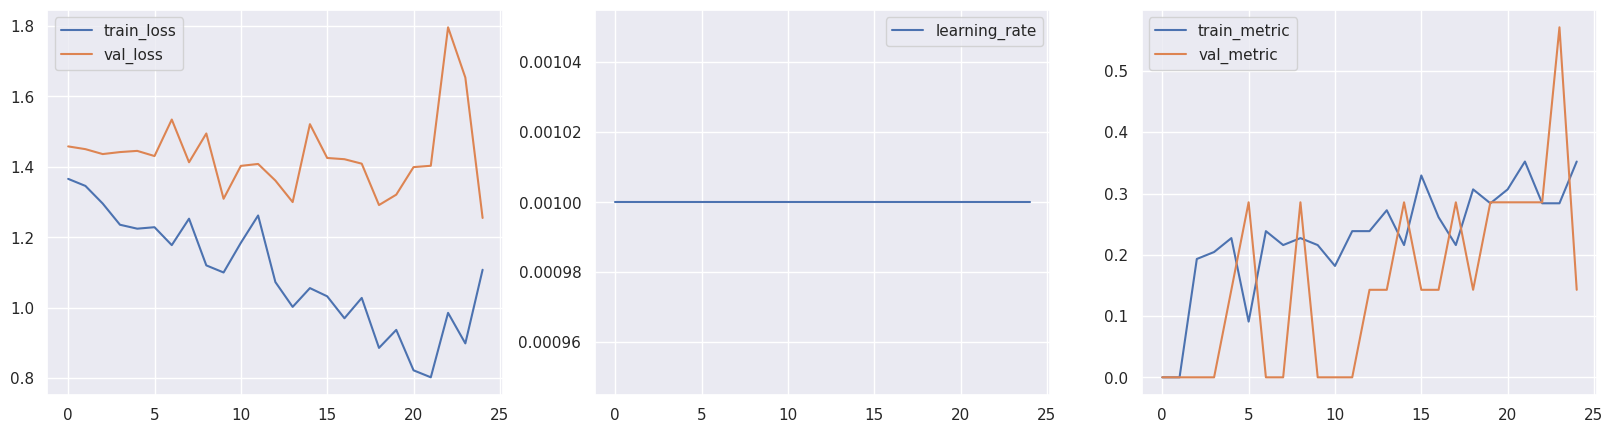

In [27]:
model_name='simple_lstm_model'
load_model_state = torch.load(f'../models/anomaly_classification_models/{model_name}.pt', map_location=torch.device(device))
plot_training_process(load_model_state)

In [46]:
load_model_state.keys()

dict_keys(['info', 'features', 'sequence_length', 'hidden_size', 'state_model', 'state_opt', 'state_lr_scheduler', 'loss', 'metric', 'lr', 'epoch'])

In [47]:
class LSTMClassifier(nn.Module):
    def __init__(self, num_features, hidden_size=64, lstm_layers=2, fc_dim=16, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers

        # Define LSTM layer with specified number of features, hidden size and layers
        self.lstm = nn.LSTM(num_features, hidden_size, lstm_layers, batch_first=True, dropout=dropout)
        # Define fully connected layers for output after LSTM
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, 1)
        )

    def forward(self, x):
        # x: [batch_size, sequence_length, num_features]
        # Initialize hidden state (h0) and cell state (c0) for LSTM
        h0 = torch.zeros(self.lstm_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.lstm_layers, x.size(0), self.hidden_size, device=x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))     # out: [batch_size, sequence_length, size]
        # Use the output from the last time step
        out = out[:, -1, :]                 # Last time step output
        # Pass through fully connected layers
        out = self.fc(out)
        return out



num_features = len(load_model_state['features'])
state_model = load_model_state['state_model']

simple_lstm_model_checkpoint = LSTMClassifier(num_features=num_features)
simple_lstm_model_checkpoint.load_state_dict(state_model)
bce_loss_model = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [106]:
y_pred_prob = test_model(simple_lstm_model_checkpoint, bce_loss_model)
y_pred_labels = (torch.tensor(y_pred) >= 0.2).float()

test_loss=0.4089, test_metric=0.0000


In [107]:
start_index = sequence_length + prediction_offset - 1
result_df = train_dataset.data.copy()
result_df[train_dataset.temp_features] = train_dataset.inverse_transform()

result_df = result_df.iloc[start_index:start_index + len(y_pred_labels)][['time', 'temp_ice', 'resurfacing']]
result_df['pred_resurfacing'] = y_pred_labels
result_df['prob_resurfacing'] = y_pred_prob

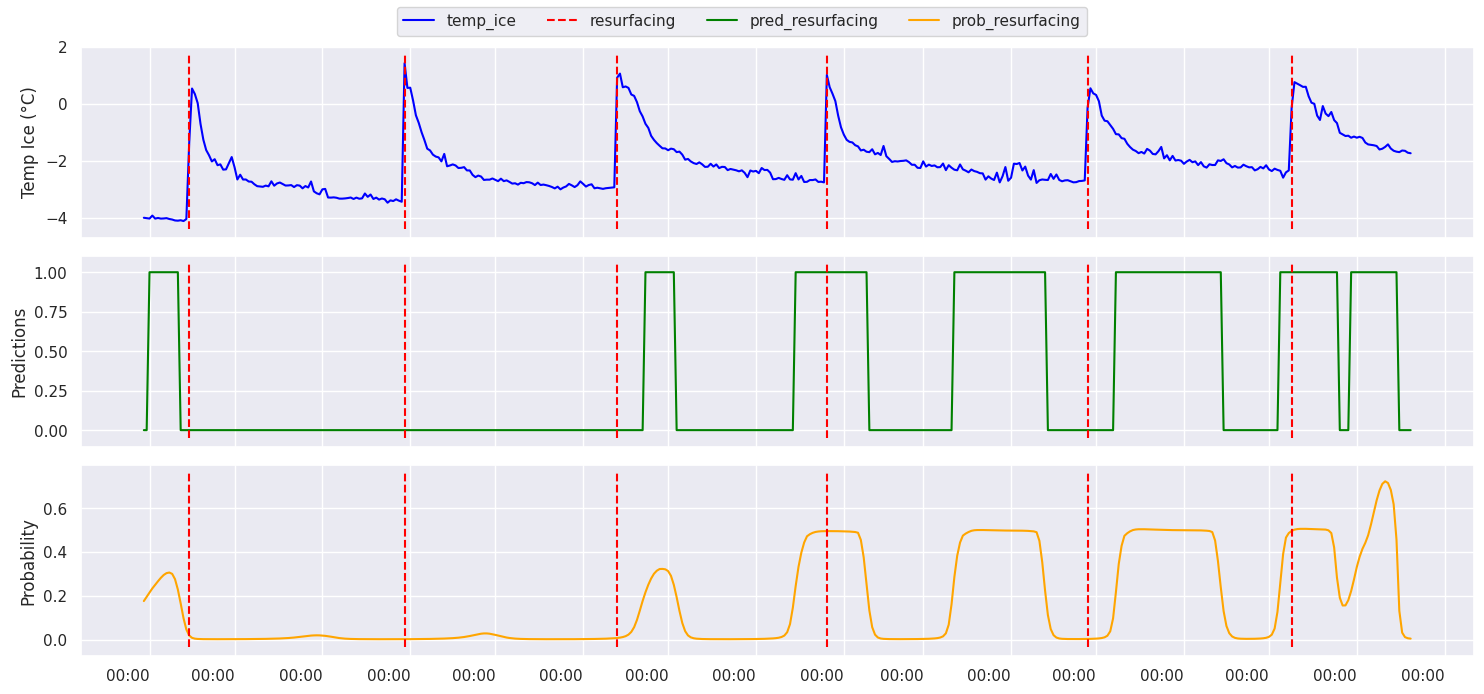

In [108]:
# Sampling the data for the desired time period
df_sample = result_df.iloc[:1440*3]

# Create the figure and axes for the subgraphs
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 7), sharex=True)

# Temperature signatures on individual subplots
axes[0].plot(df_sample.index, df_sample['temp_ice'], label='temp_ice', color='blue')
axes[0].set_ylabel('Temp Ice (°C)')

axes[1].plot(df_sample.index, df_sample['pred_resurfacing'], label='pred_resurfacing', color='green')
axes[1].set_ylabel('Predictions')

axes[2].plot(df_sample.index, df_sample['prob_resurfacing'], label='prob_resurfacing', color='orange')
axes[2].set_ylabel('Probability')

# Add vertical lines for resurfacing
for ax in axes:
    ax.vlines(df_sample[df_sample['resurfacing'] == 1].index, 
              ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], 
              color='red', linestyle='--', label='resurfacing')

# Create a common legend for all charts
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
fig.legend(handles, labels, loc='upper center', ncol=6)

# Formatting the time axis (x-axis)
locator = mdates.AutoDateLocator(minticks=5, maxticks=20)  # Automatic selection of timestamps
formatter = mdates.DateFormatter('%H:%M')  # Format timestamps without seconds
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)

# Rotate the x-axis labels for better readability
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=0, ha='right')

# Set compact layout of subgraphs
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the overall legend
plt.show()


### LSTM-autoencoder

In [46]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(Autoencoder, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


In [47]:
def train_autoencoder(autoencoder, dataloader, criterion, optimizer, num_epochs=20):
    autoencoder.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, _ in dataloader:
            batch_X = batch_X.view(-1, batch_X.size(2)).to(device)  # [batch_size * seq_len, input_dim]
            optimizer.zero_grad()
            outputs = autoencoder(batch_X)
            loss = criterion(outputs, batch_X)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        epoch_loss /= len(dataloader.dataset) * sequence_length
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


In [48]:
class EncodedDataset(Dataset):
    def __init__(self, original_dataset, autoencoder, device):
        self.dataset = original_dataset
        self.autoencoder = autoencoder
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        with torch.no_grad():
            X = X.view(-1, X.size(1)).to(self.device)  # [seq_len, input_dim]
            z = self.autoencoder.encoder(X)  # [seq_len, latent_dim]
        return z.cpu(), y


In [49]:
class LSTMWithAutoencoder(nn.Module):
    def __init__(self, latent_dim=16, lstm_hidden_size=64, lstm_layers=2, fc_dim=16, dropout=0.2):
        super(LSTMWithAutoencoder, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers

        self.lstm = nn.LSTM(latent_dim, lstm_hidden_size, lstm_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_size, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [batch_size, sequence_length, latent_dim]
        h0 = torch.zeros(self.lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        c0 = torch.zeros(self.lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))  # out: [batch_size, sequence_length, hidden_size]
        out = out[:, -1, :]  # Последнее временное состояние
        out = self.fc(out)
        return out


In [50]:
def train_lstm_with_autoencoder(model, dataloader, criterion, optimizer, num_epochs=50, patience=10):
    model.train()
    best_loss = np.inf
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        
        epoch_loss /= len(dataloader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        # Ранняя остановка
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_lstm_autoencoder_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Ранняя остановка!')
                break


In [51]:
def evaluate_lstm_with_autoencoder(model, dataloader):
    model.eval()
    all_preds = []
    all_probas = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            all_preds.extend((outputs.cpu().numpy() >= 0.5).astype(int))
            all_probas.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(batch_y.numpy())
    
    all_preds = np.array(all_preds)
    all_probas = np.array(all_probas)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision_0 = precision_score(all_labels, all_preds, pos_label=0, zero_division=0)
    recall_0 = recall_score(all_labels, all_preds, pos_label=0)
    f1_0 = f1_score(all_labels, all_preds, pos_label=0)
    
    precision_1 = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
    recall_1 = recall_score(all_labels, all_preds, pos_label=1)
    f1_1 = f1_score(all_labels, all_preds, pos_label=1)
    
    roc_auc = roc_auc_score(all_labels, all_probas)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    results = {
        'Model': 'LSTM with Autoencoder',
        'Accuracy': accuracy,
        'Precision (0)': precision_0,
        'Recall (0)': recall_0,
        'F1-Score (0)': f1_0,
        'Precision (1)': precision_1,
        'Recall (1)': recall_1,
        'F1-Score (1)': f1_1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': conf_matrix
    }
    
    return results


In [52]:
# Параметры автоэнкодера
input_dim = X_train.shape[1]
latent_dim = 16
autoencoder = Autoencoder(input_dim, latent_dim).to(device)

# Критерий и оптимизатор для автоэнкодера
criterion_ae = nn.MSELoss()
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

print("Обучение автоэнкодера:")
train_autoencoder(autoencoder, train_loader, criterion_ae, optimizer_ae, num_epochs=20)

# Фиксация параметров энкодера
for param in autoencoder.encoder.parameters():
    param.requires_grad = False

# Создание нового Dataset и DataLoader с сжатыми признаками
class EncodedDataset(Dataset):
    def __init__(self, original_dataset, autoencoder, device):
        self.dataset = original_dataset
        self.autoencoder = autoencoder
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        with torch.no_grad():
            X = X.to(self.device)
            z = self.autoencoder.encoder(X.view(-1, X.size(1)))  # [sequence_length, latent_dim]
        return z.cpu(), y

encoded_train_dataset = EncodedDataset(train_dataset, autoencoder, device)
encoded_test_dataset = EncodedDataset(test_dataset, autoencoder, device)

encoded_train_loader = DataLoader(encoded_train_dataset, batch_size=batch_size, shuffle=False)
encoded_test_loader = DataLoader(encoded_test_dataset, batch_size=batch_size, shuffle=False)

# Создание модели LSTM с автоэнкодером
lstm_autoencoder_model = LSTMWithAutoencoder(
    latent_dim=latent_dim, 
    lstm_hidden_size=64, 
    lstm_layers=2, 
    fc_dim=16, 
    dropout=0.2
).to(device)

# Определение функции потерь и оптимизатора для LSTM с автоэнкодером
# Здесь можно использовать взвешенную бинарную кросс-энтропию
criterion_lstm_autoencoder = nn.BCELoss()
optimizer_lstm_autoencoder = torch.optim.Adam(lstm_autoencoder_model.parameters(), lr=0.001)

print("Обучение LSTM модели с автоэнкодером:")
train_lstm_with_autoencoder(
    lstm_autoencoder_model, 
    encoded_train_loader, 
    criterion_lstm_autoencoder, 
    optimizer_lstm_autoencoder, 
    num_epochs=50, 
    patience=10
)


Обучение автоэнкодера:
Epoch [1/20], Loss: 0.8637
Epoch [5/20], Loss: 0.5897
Epoch [10/20], Loss: 0.5697
Epoch [15/20], Loss: 0.5185
Epoch [20/20], Loss: 0.5139
Обучение LSTM модели с автоэнкодером:
Epoch [1/50], Loss: 0.0680
Epoch [2/50], Loss: 0.0459
Epoch [3/50], Loss: 0.0454
Epoch [4/50], Loss: 0.0442
Epoch [5/50], Loss: 0.0434
Epoch [6/50], Loss: 0.0431
Epoch [7/50], Loss: 0.0427
Epoch [8/50], Loss: 0.0430
Epoch [9/50], Loss: 0.0418
Epoch [10/50], Loss: 0.0416
Epoch [11/50], Loss: 0.0421
Epoch [12/50], Loss: 0.0411
Epoch [13/50], Loss: 0.0411
Epoch [14/50], Loss: 0.0406
Epoch [15/50], Loss: 0.0405
Epoch [16/50], Loss: 0.0416
Epoch [17/50], Loss: 0.0412
Epoch [18/50], Loss: 0.0413
Epoch [19/50], Loss: 0.0400
Epoch [20/50], Loss: 0.0399
Epoch [21/50], Loss: 0.0397
Epoch [22/50], Loss: 0.0397
Epoch [23/50], Loss: 0.0403
Epoch [24/50], Loss: 0.0390
Epoch [25/50], Loss: 0.0387
Epoch [26/50], Loss: 0.0391
Epoch [27/50], Loss: 0.0396
Epoch [28/50], Loss: 0.0389
Epoch [29/50], Loss: 0.037

In [55]:
metrics_df

Model  Accuracy  Precision (0)  Recall (0)  F1-Score (0)  Precision (1)   
0  LSTM   0.99393        0.99393         1.0      0.996956            0.0  \

   Recall (1)  F1-Score (1)   ROC AUC       Confusion Matrix  
0         0.0           0.0  0.809441  [[11790, 0], [72, 0]]

In [66]:
# Загрузка лучшей модели
lstm_autoencoder_model.load_state_dict(torch.load('best_lstm_autoencoder_model.pth'))
lstm_autoencoder_model.eval()

# Оценка модели
lstm_autoencoder_results = evaluate_lstm_with_autoencoder(lstm_autoencoder_model, encoded_test_loader)

# Добавление результатов в датафрейм
lstm_autoencoder_results_df = pd.DataFrame([lstm_autoencoder_results])

# Добавление результатов в датафрейм с помощью pd.concat
metrics_df = pd.concat([metrics_df, lstm_autoencoder_results_df], ignore_index=True)

# Отображение результатов
metrics_df

Model  Accuracy  Precision (0)  Recall (0)  F1-Score (0)   
0                   LSTM  0.993930       0.993930         1.0      0.996956  \
1  LSTM with Autoencoder  0.993935       0.993935         1.0      0.996958   

   Precision (1)  Recall (1)  F1-Score (1)   ROC AUC       Confusion Matrix   
0            0.0         0.0           0.0  0.809441  [[11790, 0], [72, 0]]  \
1            0.0         0.0           0.0  0.741049  [[11799, 0], [72, 0]]   

     1  
0  NaN  
1  NaN